In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import scipy as sp
import pandas as pd
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp, odeint
import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Set directories

In [3]:
base_dir = os.getcwd().replace('\\','/') + '/'

fig_dir = base_dir + 'Figures/SOI/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'SOI_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

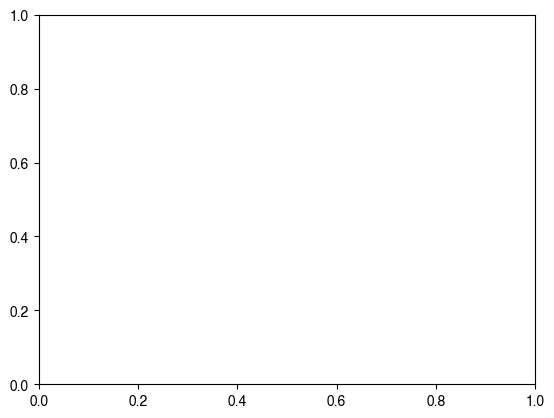

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper functions

In [5]:
tc.backends.cuda.is_built()

True

In [6]:
tc.backends.cudnn.is_available()

True

In [7]:
def lorenz(X,t,sigma=10,beta=8/3,rho=28):
    x, y, z = X
    dx = sigma*(y-x)
    dy = x*(rho-z) - y
    dz = x*y - beta*z
    return [dx, dy, dz]

def evolve(f,Tmax,dt,x0,sigma=10,beta=8/3,rho=28):
    t = np.arange(0,Tmax,dt)
    result = odeint(f, x0, t, args=(sigma,beta,rho))
    x,y,z = result.T
    return x,y,z,t

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def get_tau_crits(X_train, p_val=0.05, max_lag=600, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname=''):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else max_lag

    for i in range(N):
        lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
        amis.append(ami)
    amis = np.array(amis).T
    
    for i in range(N):
        amis[:,i] /= amis[0,i]
        
    tau_crits = []
    for i in range(N):
        for j in range(max_lag):
            if amis[j,i] <= p_val:
                break
        tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 10
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1.2]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
            ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.set_xlim(0, max_lag)
            ax.set_ylim(ylim)
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,1,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,1,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            xticks = ax.get_xticks()
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, fontsize=fontsize)
            
            # peaks = signal.argrelextrema(amis[:,i], np.greater)[0]
            # ax.plot(peaks,amis[peaks,i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{:}(\tau)$'.format(dim_labels[i]), fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs).fit(features[::stride],
                                                                                  labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs).fit(features[::stride],
                                                                                labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    return Regressor.feature_importances_, end_time-start_time

def future_prediction(features, labels, FIs, future, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='RFR', verbose=False, model_conversion=None,
                      device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
            
            
    prediction = np.zeros((future,N))
    if s is None:
        s = features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape k*xi
    s_delayed = s[:,-(k-1)*xi-1::xi] # length k

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True, model_conversion=None, device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop).reshape(-1,1)
    else:
        prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction)
        
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_true,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_true[:,i]-y_pred[:,i])**2 for i in range(y_true.shape[1])]), axis=0))

def envelope_length(y_true,y_pred,threshold=5):
    error_signal = rmse_vec(y_true,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def delay_embedding_multidimensional(input,emb_dim,n=None,tau=1):
    # input is shape (n_dims,n_samples)
    input = np.array(input)
    if n is None:
        n = input.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(input)))
    for i in range(n):
        j = i
        embedding[i,:] = input[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def AMI_summary(y_pred, y_test):
    return pyps.ami(y_pred, y_test)

In [8]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, dates,
                      xlabel='X', ylabels=None, save_fig=False, fname='', mag_format=False):
    fontsize = 24
    lw = 2
    ls_test = '-'

    plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

    annotate_xy = (0.005,0.965)

    errors = [rmse_vec(y_test,y_pred) for y_pred in pred_data_lst]
    max_error = max([max(error) for error in errors])

    N = np.shape(y_test)[1]
    if ylabels is None:
        yalbels = [f'Y{i}' for i in range(N)]

    fig = plt.figure(constrained_layout=False,figsize=(12,5*(N+2)))



    gs1 = fig.add_gridspec(nrows=4, ncols=1, left=0.05, right=0.95,
                            wspace=0.05, hspace=0.15)
    axs = []
    for i in range(N+1):
        if i == 0:
            axs.append(fig.add_subplot(gs1[0, 0]))
        else:
            axs.append(fig.add_subplot(gs1[i, 0], sharex=axs[0]))




    lines = []
    for i in range(N):
        lines.append([axs[i].plot(X_test[:,i],'k',lw=3,label=r'Test',ls=ls_test)[0]] + [axs[i].plot(pred_data_lst[j][:,i],color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
        axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
        axs[i].set_xlim(0, len(y_test)-1)

        axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

        yticks = axs[i].get_yticks()[1:-1]

        if mag_format:
            multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
            fmt = MagnitudeFormatter(multiplier)
            axs[i].yaxis.set_major_formatter(fmt)
            # plt.ticklabel_format(style='sci', axis='y')
            # print(ax.yaxis.get_major_formatter().__dict__)
            axs[i].yaxis.offsetText.set_visible(False)

            # print(yticks)
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

            if multiplier != 0:
                axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
        else:
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:}'.format(ytick) for ytick in yticks])

        plt.setp(axs[i].get_xticklabels(), visible=False)
        axs[i].tick_params(bottom=True, top=False, left=True, right=False)
        axs[i].set_zorder(N+1-i)

    i = -1
    lines.append([axs[i].plot(errors[j],color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
    axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
    axs[i].set_xlim(0, len(y_test)-1)
    axs[i].set_ylim(0, None)

    axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

    yticks = axs[i].get_yticks()[:-1]

    if mag_format:
        multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
        fmt = MagnitudeFormatter(multiplier)
        axs[i].yaxis.set_major_formatter(fmt)
        # plt.ticklabel_format(style='sci', axis='y')
        # print(ax.yaxis.get_major_formatter().__dict__)
        axs[i].yaxis.offsetText.set_visible(False)

        # print(yticks)
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

        if multiplier != 0:
            axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
    else:
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:.1f}'.format(ytick) for ytick in yticks])

    plt.setp(ax1.get_xticklabels(), visible=True)
    ax1.tick_params(bottom=True, top=False, left=True, right=False)
    ax1.set_zorder(1)

    locator = plt.MaxNLocator(5)
    axs[i].xaxis.set_major_locator(locator)

    xticks = axs[i].get_xticks().astype(int)[:-1]
    xticklabels = [dates[xtick] if type(dates[xtick])==str else dates[xtick].strftime('%m/%d/%Y') for xtick in xticks]

    # xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels, fontsize=fontsize, rotation=30, ha='center')


    axs[0].legend(handles=lines[0],loc='lower center', bbox_to_anchor=(0.5,1.025),prop={'size': fontsize},ncol=len(pred_data_lst)+1,columnspacing=1,handletextpad=0.5)
    # # fig.legend(handles=[line1,line2,line3],loc='lower center', bbox_to_anchor=(0.5,.85),prop={'size': fontsize},ncol=3)



    # plt.subplots_adjust(hspace=0, wspace=0.25)
    # plt.tight_layout()

    fig.align_labels(axs)
    # fig.align_labels([ax5,ax6])

    for i in range(N+1):
        plt.setp(axs[i].spines.values(), linewidth=3, zorder=100)
        axs[i].tick_params(length=15,width=3)

    if save_fig:
        plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
        plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

    plt.show()

In [9]:
def index_to_date_num(index,start_year,start_month):
    elapsed_years = (index+start_month-1)//12
    elapsed_months = index - elapsed_years*12
    current_year = start_year + elapsed_years
    current_month = (start_month + elapsed_months-1)%12 + 1
    return current_year*100 + current_month

months = ['Jan', 'Feb', 'Mar', 'Apr',
          'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']

# SOI

## Data

In [10]:
from urllib.request import urlretrieve

In [20]:
urlretrieve('https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat', data_dir+'soi_3dp.dat')

('E:/College/Graduate/Semester 1/Time Series Project/SOI_Data/soi_3dp.dat',
 <http.client.HTTPMessage at 0x1af963f7220>)

In [79]:
soi_df = pd.read_csv(data_dir + 'soi.dat', sep=' ', skipinitialspace=True, names=months+['Annual'])
soi_df

Jan   Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
1866 -0.62 -0.12  -0.62  -0.65   0.04  -0.82  -0.34   0.36  -0.18   0.07   
1867  0.09 -0.01  -0.09   0.83   0.50  -0.48   0.44   0.34   0.12  -0.56   
1868 -0.16 -0.34  -1.56   0.30  -1.34  -2.20  -0.40  -1.41  -1.23  -1.24   
1869 -1.90 -0.26  -0.59   2.12   1.40   1.53   1.42   0.94   0.12   0.85   
1870  1.06  0.18  -0.75   0.47  -0.11  -1.10   0.17   0.98  -0.00  -0.58   
...    ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020  0.01 -0.31  -0.75   0.16   0.71  -1.36   0.44   0.85   0.98   0.27   
2021  1.64  1.02  -0.20   0.30   0.49   0.22   1.61   0.27   0.86   0.51   
2022  0.34  0.76   1.35   2.69   1.90   2.45   0.91   0.81   1.73   1.73   
2023  1.14  0.93  -0.38  -0.03  -1.60  -0.12  -0.38  -1.60  -1.36  -0.60   
2024  0.31 -1.47 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99   

        Nov    Dec  Annual  
1866   1.10  -0.16   -0.16  
1867  -0.65  -0.89   -0.03  
1868  -1.49   0.52   -0.88  
1869   0.56   0.42    0.55  
1870  -0.86  -1.29   -0.15  
...     ...    ...     ...  
2020   0.85   1.76    0.30  
2021   1.12   1.43    0.77  
2022   0.31   2.11    1.42  
2023  -0.90  -0.39   -0.44  
2024 -99.99 -99.99  -99.99  

[159 rows x 13 columns]

In [80]:
soi, dates = soi_df[months].stack().to_numpy(), soi_df[months].stack().index.to_numpy()
dates = np.array([f'{month}, {year}' for (year, month) in dates])
soi, dates = np.delete(soi, np.where(soi == -99.99)).reshape(-1,1), np.delete(dates, np.where(soi == -99.99))
soi.shape

(1898, 1)

In [81]:
len_train = dates.tolist().index('Jan, 1984')
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


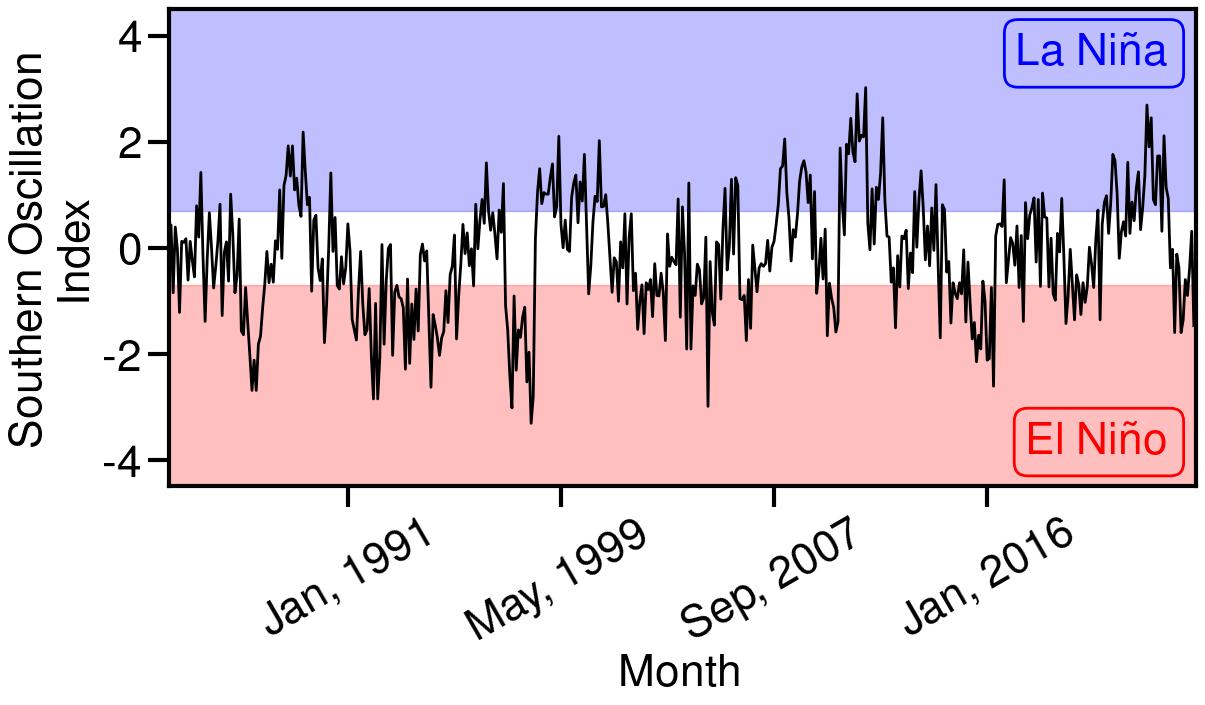

In [82]:
fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(12, 7))
ax1 = ax


# ax1.plot(soi,'k-',ms=10,lw=2)
ax1.plot(soi,'-',color='k',ms=10,lw=2,zorder=2)

# ylim = ax1.get_ylim()
ylim = [-4.5,4.5]
ax1.set_ylim(ylim)

ax1.fill_between([0, len(soi)-1],[.7]*2,[ylim[1]]*2,color='b',alpha=0.25,zorder=1)
ax1.fill_between([0, len(soi)-1],[-.7]*2,[ylim[0]]*2,color='r',alpha=0.25,zorder=1)

ax1.annotate(r'La Ni\~na', (.975,.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=fontsize, c='b',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='b',lw=2))
ax1.annotate(r'El Ni\~no', (.975,.05), xycoords='axes fraction', ha='right', va='bottom',
             fontsize=fontsize, c='r',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='r',lw=2))

# ax1.text(0.2,corr_dim+0.05,r'True $D_C = '+'{:5.4f}'.format(corr_dim)+'$',fontsize=fontsize)

# ax1.set_xlim(0,len(predicted))
# ax1.set_ylim(0.8,2.6)

# first_year = int(date_strings[0].split(' ')[1])
# last_year = int(date_strings[-1].split(' ')[1])
# num_ticks = 5
# xticklabels = np.arange(first_year,last_year,int((last_year-first_year)/num_ticks))
ax1.set_xlim(len_train,len(soi))

locator = plt.MaxNLocator(5)
ax1.xaxis.set_major_locator(locator)

xticks = ax1.get_xticks().astype(int)[1:-1]
xticklabels = [dates[xtick] for xtick in xticks]

# xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, fontsize=fontsize, rotation=30, ha='center')

ax1.set_yticks([-4,-2,0,2,4])
ax1.set_yticklabels([-4,-2,0,2,4])

# ax1.set_xlabel(r'Year',fontsize=fontsize)
ax1.set_ylabel('Southern Oscillation\nIndex',fontsize=fontsize)

left_date = 'Jan, 2012'


# ax1.set_xlim(date_strings.index(left_date), len(soi))

# num_ticks = 9
# xticks = np.linspace(date_strings.index(left_date),len(soi),num_ticks)
# ax1.set_xticks(xticks)

# xticks = ax1.get_xticks()
# xticklabels = [format_date(index_to_date_num(int(xtick)-date_strings.index(left_date),
#                int(left_date.split(',')[1]),months.index(left_date.split(',')[0]))) for xtick in xticks]
# ax1.set_xticklabels(xticklabels, rotation=30, ha='center', fontsize=fontsize)

ax1.set_xlabel('Month',fontsize=fontsize)


plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax1.tick_params(length=15,width=3)
plt.setp(ax1.spines.values(), linewidth=3, zorder=10)

title = 'Test SOI Data'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

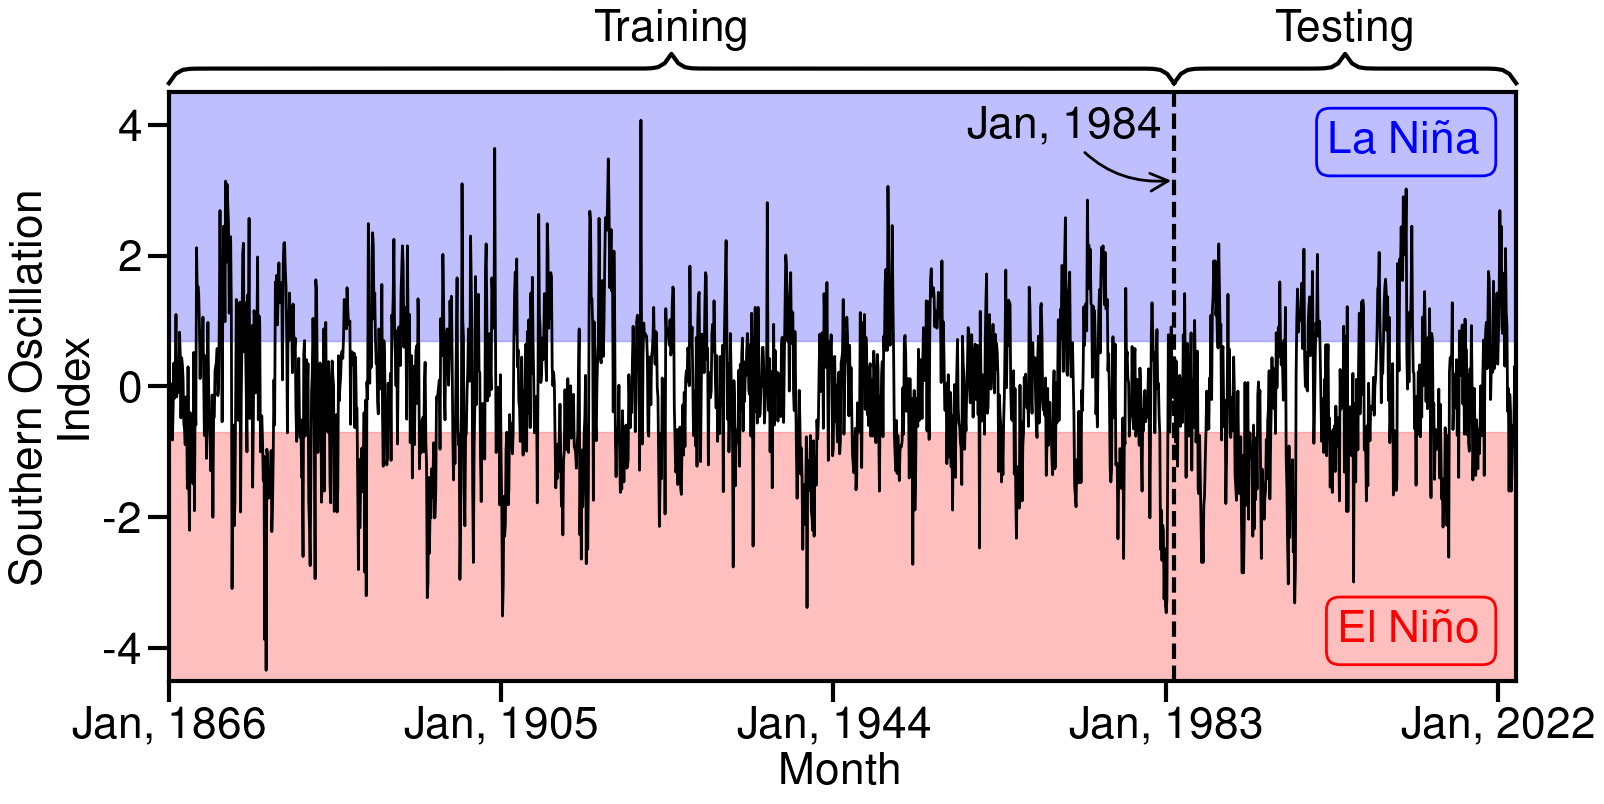

In [83]:
fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(16, 8))


def draw_brace(ax, xspan, yy, text, lw=3):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=lw, clip_on=False)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', fontsize=fontsize)


# ax.plot(soi,'k-',ms=10,lw=2)
ax.plot(soi,'-',color='k',ms=10,lw=2,zorder=2)

# ylim = ax.get_ylim()
ylim = [-4.5,4.5]
ax.set_ylim(ylim)

ax.fill_between([0, len(soi)-1],[.7]*2,[ylim[1]]*2,color='b',alpha=0.25,zorder=1)
ax.fill_between([0, len(soi)-1],[-.7]*2,[ylim[0]]*2,color='r',alpha=0.25,zorder=1)

ax.annotate(r'La Ni\~na', (.975,.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=fontsize, c='b',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='b',lw=2))
ax.annotate(r'El Ni\~no', (.975,.05), xycoords='axes fraction', ha='right', va='bottom',
             fontsize=fontsize, c='r',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='r',lw=2))

# ax.text(0.2,corr_dim+0.05,r'True $D_C = '+'{:5.4f}'.format(corr_dim)+'$',fontsize=fontsize)

# ax.set_xlim(0,len(predicted))
# ax.set_ylim(0.8,2.6)

# first_year = int(date_strings[0].split(' ')[1])
# last_year = int(date_strings[-1].split(' ')[1])
# num_ticks = 5
# xticklabels = np.arange(first_year,last_year,int((last_year-first_year)/num_ticks))
# ax.set_xlim(len_train,len(soi))
ax.set_xlim(0,len(soi))

# locator = plt.MaxNLocator(5)
# ax.xaxis.set_major_locator(locator)

# xticks = ax.get_xticks().astype(int)[:-1]

xticks = np.arange(0,len(dates),len(dates)//4//12*12)
xticklabels = [dates[xtick] for xtick in xticks]

# xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=0, ha='center')

ax.set_yticks([-4,-2,0,2,4])
ax.set_yticklabels([-4,-2,0,2,4])

# ax.set_xlabel(r'Year',fontsize=fontsize)
ax.set_ylabel('Southern Oscillation\nIndex',fontsize=fontsize)

# left_date = 'Jan, 2012'


# ax.set_xlim(date_strings.index(left_date), len(soi))

# num_ticks = 9
# xticks = np.linspace(date_strings.index(left_date),len(soi),num_ticks)
# ax.set_xticks(xticks)

# xticks = ax.get_xticks()
# xticklabels = [format_date(index_to_date_num(int(xtick)-date_strings.index(left_date),
#                int(left_date.split(',')[1]),months.index(left_date.split(',')[0]))) for xtick in xticks]
# ax.set_xticklabels(xticklabels, rotation=30, ha='center', fontsize=fontsize)

ax.set_xlabel('Month',fontsize=fontsize)


draw_brace(ax, (0,len_train), ax.get_ylim()[-1], 'Training', lw=3)
draw_brace(ax, (len_train,len(soi)), ax.get_ylim()[-1], 'Testing', lw=3)
ax.axvline(len_train, c='k', ls='--', lw=3)
ax.annotate('Jan, 1984', xytext=(len_train-0.01*len(soi),ax.get_ylim()[-1]-0.025*np.diff(ax.get_ylim())[0]),
            textcoords='data', fontsize=fontsize, ha='right', va='top',
            xy=(len_train,ax.get_ylim()[-1]-0.15*np.diff(ax.get_ylim())[0]),
            xycoords='data', arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.3", lw=2))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax.tick_params(length=15,width=3)
plt.setp(ax.spines.values(), linewidth=3, zorder=10)

title = 'Raw SOI Data'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

## RC

In [26]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [27]:
rpy.verbosity(0)

0

In [28]:
num_runs = 20
leads = [1,3,6,12]
y_preds_RC = []
runtimes_RC = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_RC.append([None]*num_runs)
    runtimes_RC.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        units = 100
        leak_rate = 0.5
        spectral_radius = 1.01
        input_scaling = 1.0
        connectivity = 0.1
        input_connectivity = 1
        regularization = 1e-8
    #     seed = 1234

        reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                  lr=leak_rate, rc_connectivity=connectivity,
                                  input_connectivity=input_connectivity)
        readout = Ridge(X_train.shape[1], ridge=regularization)

        model = reservoir >> readout

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.transform(y_train)
        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = scaler.transform(y_test)

        rc = model.fit(X_train_scaled, y_train_scaled)





        seed_timesteps = 100

        warming_inputs = X_train_scaled[-seed_timesteps:]

        warming_out = rc.run(warming_inputs, reset=True)  # warmup

        nb_generations = len(X_test_scaled)

        y_pred = np.zeros((nb_generations, X_test_scaled.shape[1]))
        y_warm = X_test_scaled[0]#warming_out[-1]
        for i in range(nb_generations):  # generation
            y_warm = rc(y_warm)
            y_pred[i, :] = y_warm
            y_warm = y_test_scaled[i]

        y_pred = scaler.inverse_transform(y_pred)
        end_time = time.time()


        y_preds_RC[i_lead][i_run] = y_pred
        runtimes_RC[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_RC[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_RC[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8927069539253003 0.28513644233607227


  0%|          | 0/20 [00:00<?, ?it/s]

3 0.9578049940207259 0.22559589531869007


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.0712855803342507 0.14612246500842316


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.3198838617202346 0.0911209104352792


## NG-RC

In [29]:
num_runs = 20
leads = [1,3,6,12]
y_preds_NGRC = []
runtimes_NGRC = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_NGRC.append([None]*num_runs)
    runtimes_NGRC.append([None]*num_runs)

    X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)


    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        # discrete-time versions of the times defined above
        warmup_pts=100
        traintime_pts=len(X_train)-warmup_pts
        warmtrain_pts=warmup_pts+traintime_pts
        testtime_pts=len(X_test)
        maxtime_pts=len(X_train)+len(X_test)#+warmup_pts
        # plottime_pts=round(plottime/dt)
        # lyaptime_pts=round(lyaptime/dt)

        # input dimension
        d = 1
        # number of time delay taps
        k = 1*12
        # size of linear part of feature vector
        dlin = k*d
        # size of nonlinear part of feature vector
        dnonlin = int(dlin*(dlin+1)/2)
        # total size of feature vector: constant + linear + nonlinear
        dtot = 1 + dlin + dnonlin

        # ridge parameter for regression
        ridge_param = 1e-4

        # t values for whole evaluation time
        # (need maxtime_pts + 1 to ensure a step of dt)
        # t_eval=np.linspace(0,maxtime,maxtime_pts+1)


        ##
        ## NVAR
        ##

        # create an array to hold the linear part of the feature vector
        x = np.zeros((dlin,maxtime_pts))

        # fill in the linear part of the feature vector for all times
        for delay in range(k):
            for j in range(delay,maxtime_pts):
                x[d*delay:d*(delay+1),j]=soi[j-delay,:]

        # create an array to hold the full feature vector for training time
        # (use ones so the constant term is already 1)
        out_train = np.ones((dtot,traintime_pts))

        # copy over the linear part (shift over by one to account for constant)
        out_train[1:dlin+1,:]=x[:,warmup_pts-lead:warmtrain_pts-lead]

        # fill in the non-linear part
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                # shift by one for constant
                out_train[dlin+1+cnt]=x[row,warmup_pts-lead:warmtrain_pts-lead]*x[column,warmup_pts-lead:warmtrain_pts-lead]
                cnt += 1

        # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
        W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-lead:warmtrain_pts-lead]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))




        X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
        # print(X_train.shape, X_test.shape)



        y_pred = np.zeros(y_test.shape)


        for i in range(len(y_pred)):
            x_test = soi[len(X_train)-dlin-lead+2+i:len(X_train)-lead+2+i].T.flatten()[::-1]


            # create a place to store feature vectors for prediction
            out_test = np.zeros(dtot)   # full feature vector
            # x_test = np.zeros((dlin))   # linear part


            # copy linear part into whole feature vector
            out_test[1:dlin+1]=x_test # shift by one for constant
            # fill in the non-linear part
            cnt=0
            for row in range(dlin):
                for column in range(row,dlin):
                    # shift by one for constant
                    out_test[dlin+1+cnt]=x_test[row]*x_test[column]
                    cnt += 1

            # fill in the delay taps of the next state
            x_test[d:dlin]=x_test[0:(dlin-d)]
            # do a prediction
            x_test[0:d] = x_test[0:d]+W_out @ out_test[:]


            y_pred[i] = x_test[0]

        # test_RMSE = RMSE_summary(y_pred, y_test)
        # test_PCC = PCC_summary(y_pred, y_test)
        # print(lead, test_RMSE, test_PCC)
        end_time = time.time()


        y_preds_NGRC[i_lead][i_run] = y_pred
        runtimes_NGRC[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_NGRC[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_NGRC[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8769650040393049 0.28030880691484883


  0%|          | 0/20 [00:00<?, ?it/s]

3 0.9973115380904064 0.1751065990473943


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.108978378604348 0.13821067767405001


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.194851665208867 0.0950714552468855


## LSTM

In [30]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, (h_n, c_n) = self.lstm(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, (h_n, c_n) = self.lstm(out.reshape(1,-1), (h_n, c_n))
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [32]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [33]:
tc.set_default_dtype(tc.float)

In [51]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_LSTM = []
runtimes_LSTM = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_LSTM.append([None]*num_runs)
    runtimes_LSTM.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        k_LSTM = 1*12
        n = len(X_train)-k_LSTM-1

        features, _ = make_features_and_labels(X_train[:-1],k_LSTM,lead=lead)
        labels, _ = make_features_and_labels(X_train[1:],k_LSTM,lead=lead)


        N = X_train.shape[1]



        num_epochs = 100
        batch_size = 10
        warmup = 100
        dropout = 0.2
        num_layers = 2
        hidden_size = 20

        scaler = StandardScaler()
        scaler = scaler.fit(features)

        X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
        y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

        X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_LSTM, lead=lead)[0]), device=device, dtype=tc.float)


        model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)

        loss_fn = nn.MSELoss() #nn.MSELoss()
        # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
        optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

        start = 1e9
        scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

        model.to(device)

        model.train()

        train_losses = np.zeros((num_epochs,))
        test_RMSEs = np.zeros((num_epochs,))
        test_PCCs = np.zeros((num_epochs,))

        test_RMSE = 1e9
        for epoch in range(num_epochs):#, leave=False):
            model.train()
            for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
            if epoch > start:
                scheduler.step()
            model.eval()
            with tc.no_grad():
                y_out = model(X_test_tensor_w_warmup)
                y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_LSTM)), (0,2,1))[warmup-k_LSTM-lead+1:, -1, :]

        model.eval()
        end_time = time.time()


        y_preds_LSTM[i_lead][i_run] = y_pred
        runtimes_LSTM[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_LSTM[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_LSTM[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8913993747810615 0.2912085415106299


  0%|          | 0/20 [00:00<?, ?it/s]

3 1.0865776840430632 0.1356449952394942


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.284936171666069 0.09647009325651673


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.348677054401035 0.10938703031693912


## RNN

In [35]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [36]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        # self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity='tanh')
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, h_n = self.rnn(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, h_n = self.rnn(out.reshape(1,-1), h_n)
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [37]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_RNN = []
runtimes_RNN = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_RNN.append([None]*num_runs)
    runtimes_RNN.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        k_RNN = 1*12
        n = len(X_train)-k_RNN-1

        features, _ = make_features_and_labels(X_train[:-1],k_RNN,lead=lead)
        labels, _ = make_features_and_labels(X_train[1:],k_RNN,lead=lead)


        N = X_train.shape[1]



        num_epochs = 100
        batch_size = 10
        warmup = 100
        dropout = 0.2
        num_layers = 2
        hidden_size = 20

        scaler = StandardScaler()
        scaler = scaler.fit(features)

        X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
        y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

        X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_RNN, lead=lead)[0]), device=device, dtype=tc.float)


        model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)

        loss_fn = nn.MSELoss() #nn.MSELoss()
        # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
        optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

        start = 1e9
        scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

        model.to(device)

        model.train()

        train_losses = np.zeros((num_epochs,))
        test_RMSEs = np.zeros((num_epochs,))
        test_PCCs = np.zeros((num_epochs,))

        test_RMSE = 1e9
        for epoch in range(num_epochs):#, leave=False):
            model.train()
            for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
            if epoch > start:
                scheduler.step()
            model.eval()
            with tc.no_grad():
                y_out = model(X_test_tensor_w_warmup)
                y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_RNN)), (0,2,1))[warmup-k_RNN-lead+1:, -1, :]

        model.eval()
        end_time = time.time()


        y_preds_RNN[i_lead][i_run] = y_pred
        runtimes_RNN[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_RNN[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_RNN[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8840364740651315 0.2940991602944941


  0%|          | 0/20 [00:00<?, ?it/s]

3 1.0913277570432864 0.12896430817139964


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.2840937047094505 0.09527501835322152


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.3413951245966533 0.10213845057354017


## TreeDOX

In [92]:
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


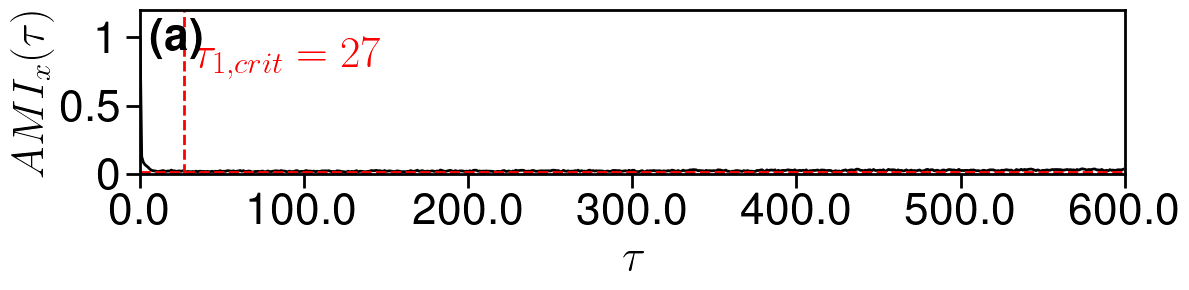

In [93]:
tau_crits = get_tau_crits(X_train, p_val=0.015, max_lag=600, make_plot=True)

In [94]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

num_runs = 20
leads = [1,3,6,12]
y_preds_TreeDOX = []
runtimes_TreeDOX = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)

    features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=lead)
    # print(features.shape, labels.shape)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                            max_depth=None, random_state=None,
                                            n_jobs=-1, n_samples=None,
                                            model_type='ETR')

        y_pred, model, time_elapsed = future_prediction_lead(features, labels, FIs,
                                                             len(y_test), lead=lead,
                                                             p=1.0, xi=xi,
                                                             n_estimators=100,
                                                             disp_progress=False,
                                                             desc=str(lead),
                                                             leave=False,
                                                             max_depth=None,
                                                             random_state=None,
                                                             n_jobs=-1,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             ccp_alpha=0,
                                                             max_features=0.5,
                                                             n_samples=None,
                                                             model=None,
                                                             y_train=y_train,
                                                             y_test=y_test,
                                                             model_type='ETR',
                                                             verbose=False,
                                                             open_loop=True,
                                                             model_conversion=None,
                                                             device='cuda')
        end_time = time.time()
        y_preds_TreeDOX[i_lead][i_run] = y_pred
        runtimes_TreeDOX[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_TreeDOX[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_lead][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 28


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8611312773298485 0.3197313999797843


  0%|          | 0/20 [00:00<?, ?it/s]

3 0.9767035932602124 0.1966364682199738


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.081721434189582 0.12578555891551005


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.1524364546839654 0.09959914644746251


## Plots

In [98]:
with gzip.open(data_dir + 'SOI_results.data', 'wb') as file:
    for var in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX,
                runtimes_RNN, runtimes_LSTM, runtimes_RC, runtimes_NGRC, runtimes_TreeDOX]:
        pkl.dump(var, file)

In [17]:
leads = [1,3,6,12]
with gzip.open(data_dir + 'SOI_results.data', 'rb') as file:
    for name in ['y_preds_RNN', 'y_preds_LSTM', 'y_preds_RC', 'y_preds_NGRC', 'y_preds_TreeDOX',
               'runtimes_RNN', 'runtimes_LSTM', 'runtimes_RC', 'runtimes_NGRC', 'runtimes_TreeDOX']:
        globals()[name] = pkl.load(file)

In [95]:
soi_rmse = [[[RMSE_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_pcc = [[[PCC_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_ami = [[[AMI_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_runtimes = [[[runtimes[i_lead][i_run] for i_run in range(len(runtimes[i_lead]))] for i_lead in range(len(leads))] for runtimes in [runtimes_RNN, runtimes_LSTM, runtimes_RC, runtimes_NGRC, runtimes_TreeDOX]]

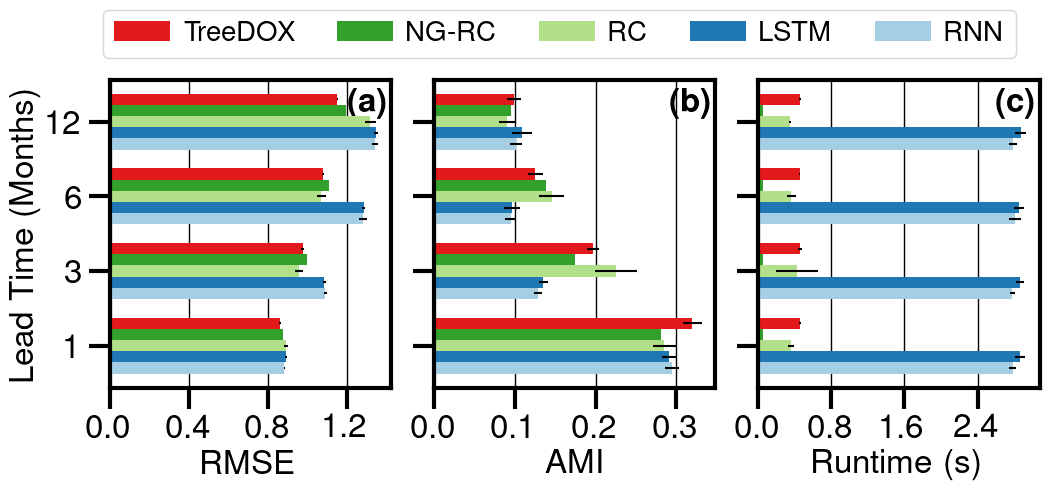

In [97]:
fname = 'SOI - TreeDOX vs RNN, LSTM, RC, NG-RC'

fontsize = 24
legendfontsize = 20

annotate_xy = (1-0.01,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

vars = ['soi_rmse', 'soi_ami', 'soi_runtimes']
var_labels = ['RMSE', 'AMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.1f', '.1f', '.1f']

fig, axs = plt.subplots(1,len(vars),figsize=(4*len(vars),4), sharey=True)
plt.subplots_adjust(wspace=0.15, hspace=0.25)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

x = np.arange(len(soi_rmse[0]))
width = 1.0/(len(labels)+1)*.9

xlim_stretch = 0.0

for i_var in range(len(vars)):
    ax = axs[i_var]

    var = globals()[vars[i_var]]

    for i_label, label in enumerate(labels):
        offset = width*i_label
        rects = ax.barh(x+offset, np.mean(var[i_label], axis=1), width, label=label, color=color_lst[i_label], zorder=10)
        ax.errorbar(np.mean(var[i_label], axis=1), x+offset, xerr=np.std(var[i_label], axis=1), fmt='none', color='k', zorder=20)
        # ax.bar_label(rects, padding=3)

    ax.axvline(0,ls='-',c='k',lw=3,zorder=0)

    if i_var == 0:
        ax.set_ylabel('Lead Time (Months)', fontsize=fontsize)
    ax.set_xlabel(var_labels[i_var], fontsize=fontsize)
    ax.set_yticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    ax.set_yticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='right')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})

    if i_var == 0:
        ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1] + xlim_stretch*np.diff(xlim))
#     if i_var == 0:
    xticks = ax.get_xticks()[:-1]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(f'{xtick:{fmts[i_var]}}' for xtick in xticks)
    
    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)
    
    ax.xaxis.grid(True, c='k', lw=1, zorder=0)
    
    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='right', va='top', xycoords="axes fraction",fontsize=fontsize)

    if i_var == 0:
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::-1], leg_labels[::-1], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                      columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

# Vary Training Length

## Data

In [55]:
from urllib.request import urlretrieve

In [56]:
urlretrieve('https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat', data_dir+'soi_3dp.dat')

('E:/College/Graduate/Semester 1/Time Series Project/SOI_Data/soi_3dp.dat',
 <http.client.HTTPMessage at 0x1afab3b7700>)

In [57]:
soi_df = pd.read_csv(data_dir + 'soi.dat', sep=' ', skipinitialspace=True, names=months+['Annual'])
soi_df

Jan   Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
1866 -0.62 -0.12  -0.62  -0.65   0.04  -0.82  -0.34   0.36  -0.18   0.07   
1867  0.09 -0.01  -0.09   0.83   0.50  -0.48   0.44   0.34   0.12  -0.56   
1868 -0.16 -0.34  -1.56   0.30  -1.34  -2.20  -0.40  -1.41  -1.23  -1.24   
1869 -1.90 -0.26  -0.59   2.12   1.40   1.53   1.42   0.94   0.12   0.85   
1870  1.06  0.18  -0.75   0.47  -0.11  -1.10   0.17   0.98  -0.00  -0.58   
...    ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020  0.01 -0.31  -0.75   0.16   0.71  -1.36   0.44   0.85   0.98   0.27   
2021  1.64  1.02  -0.20   0.30   0.49   0.22   1.61   0.27   0.86   0.51   
2022  0.34  0.76   1.35   2.69   1.90   2.45   0.91   0.81   1.73   1.73   
2023  1.14  0.93  -0.38  -0.03  -1.60  -0.12  -0.38  -1.60  -1.36  -0.60   
2024  0.31 -1.47 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99 -99.99   

        Nov    Dec  Annual  
1866   1.10  -0.16   -0.16  
1867  -0.65  -0.89   -0.03  
1868  -1.49   0.52   -0.88  
1869   0.56   0.42    0.55  
1870  -0.86  -1.29   -0.15  
...     ...    ...     ...  
2020   0.85   1.76    0.30  
2021   1.12   1.43    0.77  
2022   0.31   2.11    1.42  
2023  -0.90  -0.39   -0.44  
2024 -99.99 -99.99  -99.99  

[159 rows x 13 columns]

In [58]:
soi, dates = soi_df[months].stack().to_numpy(), soi_df[months].stack().index.to_numpy()
dates = np.array([f'{month}, {year}' for (year, month) in dates])
soi, dates = np.delete(soi, np.where(soi == -99.99)).reshape(-1,1), np.delete(dates, np.where(soi == -99.99))
soi.shape

(1898, 1)

In [59]:
len_train = dates.tolist().index('Jan, 1984')
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


In [60]:
train_sizes = (len_train*np.arange(0,1.001,0.125)[1:]).astype(int)
print(train_sizes, np.array(dates)[train_sizes], sep='\n')

[ 177  354  531  708  885 1062 1239 1416]
['Oct, 1880' 'Jul, 1895' 'Apr, 1910' 'Jan, 1925' 'Oct, 1939' 'Jul, 1954' 'Apr, 1969' 'Jan, 1984']


## RC

In [61]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [62]:
rpy.verbosity(0)

0

In [63]:
num_runs = 20
leads = [1,3,6,12]
y_preds_RC_dict = {}
runtimes_RC_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_RC_dict[train_size] = []
    runtimes_RC_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_RC_dict[train_size].append([None]*num_runs)
        runtimes_RC_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            units = 100
            leak_rate = 0.5
            spectral_radius = 1.01
            input_scaling = 1.0
            connectivity = 0.1
            input_connectivity = 1
            regularization = 1e-8
        #     seed = 1234

            reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                      lr=leak_rate, rc_connectivity=connectivity,
                                      input_connectivity=input_connectivity)
            readout = Ridge(X_train.shape[1], ridge=regularization)

            model = reservoir >> readout

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            y_train_scaled = scaler.transform(y_train)
            X_test_scaled = scaler.transform(X_test)
            y_test_scaled = scaler.transform(y_test)

            rc = model.fit(X_train_scaled, y_train_scaled)





            seed_timesteps = 100

            warming_inputs = X_train_scaled[-seed_timesteps:]

            warming_out = rc.run(warming_inputs, reset=True)  # warmup

            nb_generations = len(X_test_scaled)

            y_pred = np.zeros((nb_generations, X_test_scaled.shape[1]))
            y_warm = X_test_scaled[0]#warming_out[-1]
            for i in range(nb_generations):  # generation
                y_warm = rc(y_warm)
                y_pred[i, :] = y_warm
                y_warm = y_test_scaled[i]

            y_pred = scaler.inverse_transform(y_pred)
            end_time = time.time()


            y_preds_RC_dict[train_size][i_lead][i_run] = y_pred
            runtimes_RC_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/8 [00:00<?, ?it/s]

177:   0%|          | 0/4 [00:00<?, ?it/s]

354:   0%|          | 0/4 [00:00<?, ?it/s]

531:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

885:   0%|          | 0/4 [00:00<?, ?it/s]

1062:   0%|          | 0/4 [00:00<?, ?it/s]

1239:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
for train_size in train_sizes:
    for i_lead in range(len(leads)):
        print(train_size, i_lead, np.mean([RMSE_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_RC_dict[train_size][i_lead]))]))

177 0 2.4792034157757223
177 1 2.412909259070275
177 2 2.633322889700834
177 3 3.5484733750266253
354 0 1.192250160808538
354 1 1.2944227219735909
354 2 1.4844287267135066
354 3 1.934320875733284
531 0 1.0381901230674278
531 1 1.0842768040851745
531 2 1.202007000307671
531 3 1.6179765803846222
708 0 0.9887739885720475
708 1 1.107280456669716
708 2 1.125671918157218
708 3 1.462238956948395
885 0 0.9547026970704883
885 1 1.0231895781423126
885 2 1.1092961642754129
885 3 1.43565704528872
1062 0 0.919573445957728
1062 1 1.0158002453798423
1062 2 1.0841371382193974
1062 3 1.375734702057267
1239 0 0.899688332927991
1239 1 0.979118354950919
1239 2 1.0888160375493965
1239 3 1.3391105675611563
1416 0 0.8915178517123156
1416 1 0.9573336075820122
1416 2 1.0679707594284849
1416 3 1.3268132208135586


## NG-RC

In [64]:
num_runs = 20
leads = [1,3,6,12]
y_preds_NGRC_dict = {}
runtimes_NGRC_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_NGRC_dict[train_size] = []
    runtimes_NGRC_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False):
        lead = leads[i_lead]
        y_preds_NGRC_dict[train_size].append([None]*num_runs)
        runtimes_NGRC_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]


        for i_run in range(num_runs):
            start_time = time.time()
            # discrete-time versions of the times defined above
            warmup_pts=100
            traintime_pts=len(X_train)-warmup_pts
            warmtrain_pts=warmup_pts+traintime_pts
            testtime_pts=len(X_test)
            maxtime_pts=len(X_train)+len(X_test)#+warmup_pts
            # plottime_pts=round(plottime/dt)
            # lyaptime_pts=round(lyaptime/dt)

            # input dimension
            d = 1
            # number of time delay taps
            k = 1*12
            # size of linear part of feature vector
            dlin = k*d
            # size of nonlinear part of feature vector
            dnonlin = int(dlin*(dlin+1)/2)
            # total size of feature vector: constant + linear + nonlinear
            dtot = 1 + dlin + dnonlin

            # ridge parameter for regression
            ridge_param = 1e-4

            # t values for whole evaluation time
            # (need maxtime_pts + 1 to ensure a step of dt)
            # t_eval=np.linspace(0,maxtime,maxtime_pts+1)


            ##
            ## NVAR
            ##

            # create an array to hold the linear part of the feature vector
            x = np.zeros((dlin,maxtime_pts))

            # fill in the linear part of the feature vector for all times
            for delay in range(k):
                for j in range(delay,maxtime_pts):
                    x[d*delay:d*(delay+1),j]=soi[j-delay,:]

            # create an array to hold the full feature vector for training time
            # (use ones so the constant term is already 1)
            out_train = np.ones((dtot,traintime_pts))

            # copy over the linear part (shift over by one to account for constant)
            out_train[1:dlin+1,:]=x[:,warmup_pts-lead:warmtrain_pts-lead]

            # fill in the non-linear part
            cnt=0
            for row in range(dlin):
                for column in range(row,dlin):
                    # shift by one for constant
                    out_train[dlin+1+cnt]=x[row,warmup_pts-lead:warmtrain_pts-lead]*x[column,warmup_pts-lead:warmtrain_pts-lead]
                    cnt += 1

            # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
            W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-lead:warmtrain_pts-lead]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))




#             X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
            # print(X_train.shape, X_test.shape)



            y_pred = np.zeros(y_test.shape)


            for i in range(len(y_pred)):
                x_test = soi[len(X_train)-dlin-lead+2+i:len(X_train)-lead+2+i].T.flatten()[::-1]


                # create a place to store feature vectors for prediction
                out_test = np.zeros(dtot)   # full feature vector
                # x_test = np.zeros((dlin))   # linear part


                # copy linear part into whole feature vector
                out_test[1:dlin+1]=x_test # shift by one for constant
                # fill in the non-linear part
                cnt=0
                for row in range(dlin):
                    for column in range(row,dlin):
                        # shift by one for constant
                        out_test[dlin+1+cnt]=x_test[row]*x_test[column]
                        cnt += 1

                # fill in the delay taps of the next state
                x_test[d:dlin]=x_test[0:(dlin-d)]
                # do a prediction
                x_test[0:d] = x_test[0:d]+W_out @ out_test[:]


                y_pred[i] = x_test[0]

            # test_RMSE = RMSE_summary(y_pred, y_test)
            # test_PCC = PCC_summary(y_pred, y_test)
            # print(lead, test_RMSE, test_PCC)
            end_time = time.time()


            y_preds_NGRC_dict[train_size][i_lead][i_run] = y_pred
            runtimes_NGRC_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [69]:
for train_size in train_sizes:
    for i_lead in range(len(leads)):
        print(train_size, i_lead, np.mean([RMSE_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_NGRC_dict[train_size][i_lead]))]))

177 0 3.0058907989629686
177 1 3.0407209898992344
177 2 3.059759335705283
177 3 2.461483066517993
354 0 1.5958872636389398
354 1 1.5975177603897275
354 2 1.5823417145741534
354 3 1.6071947718961126
531 0 1.3477463456108192
531 1 1.3447829490681318
531 2 1.3025464052105642
531 3 1.3055423873715495
708 0 1.4388329651138259
708 1 1.3489386077022627
708 2 1.2776131872028462
708 3 1.3669629968185109
885 0 1.3828125955894375
885 1 1.2972822770755232
885 2 1.3018126993905006
885 3 1.2261567723708966
1062 0 1.3908735930842306
1062 1 1.300242441363797
1062 2 1.3352781072937643
1062 3 1.274317822495547
1239 0 1.1950696041515452
1239 1 1.1805957759336076
1239 2 1.2894911568378158
1239 3 1.2413112469666365
1416 0 0.8744999148274998
1416 1 1.0755437482273547
1416 2 1.2008529120843687
1416 3 1.2424674441544434


## LSTM

In [65]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [66]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(len(x)):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(min(warmup,len(x))):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out

        # # out = x[warmup-1]
        # for i in range(warmup,len(x)):
        #   out, h_n = self.lstm(out.reshape(1,-1), h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output

        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, (h_n, c_n) = self.lstm(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, (h_n, c_n) = self.lstm(out.reshape(1,-1), (h_n, c_n))
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [67]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [68]:
tc.set_default_dtype(tc.float)

In [69]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_LSTM_dict = {}
runtimes_LSTM_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_LSTM_dict[train_size] = []
    runtimes_LSTM_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_LSTM_dict[train_size].append([None]*num_runs)
        runtimes_LSTM_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            k_LSTM = 1*12
            n = len(X_train)-k_LSTM-1

            features, _ = make_features_and_labels(X_train[:-1],k_LSTM,lead=lead)
            labels, _ = make_features_and_labels(X_train[1:],k_LSTM,lead=lead)

            N = X_train.shape[1]



            num_epochs = 100
            batch_size = 10
            warmup = 100
            dropout = 0.2
            num_layers = 2
            hidden_size = 20

            scaler = StandardScaler()
            scaler = scaler.fit(features)

            X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
            y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

            X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_LSTM, lead=lead)[0]), device=device, dtype=tc.float)


            model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)
            swa_model = tc.optim.swa_utils.AveragedModel(model)

            loss_fn = nn.MSELoss() #nn.MSELoss()
            # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
            optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)
            optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

            start = 1e9
            scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)


            model.to(device)

            model.train()

            train_losses = np.zeros((num_epochs,))
            test_RMSEs = np.zeros((num_epochs,))
            test_PCCs = np.zeros((num_epochs,))

            test_RMSE = 1e9
            for epoch in range(num_epochs):#, leave=False):
                model.train()
                for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                    y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                    loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                    optimizer.zero_grad()
                    loss.backward()
                    # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                if epoch > start:
                    scheduler.step()
                model.eval()
                with tc.no_grad():
                    y_out = model(X_test_tensor_w_warmup)
                    y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_LSTM)), (0,2,1))[warmup-k_LSTM-lead+1:, -1, :]


            model.eval()
            end_time = time.time()


            y_preds_LSTM_dict[train_size][i_lead][i_run] = y_pred
            runtimes_LSTM_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/8 [00:00<?, ?it/s]

177:   0%|          | 0/4 [00:00<?, ?it/s]

354:   0%|          | 0/4 [00:00<?, ?it/s]

531:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

885:   0%|          | 0/4 [00:00<?, ?it/s]

1062:   0%|          | 0/4 [00:00<?, ?it/s]

1239:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
for train_size in train_sizes:
    for i_lead in range(len(leads)):
        print(train_size, i_lead, np.mean([RMSE_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_LSTM_dict[train_size][i_lead]))]))

177 0 0.9676447011816244
177 1 1.1368049031032355
177 2 1.3426767283674057
177 3 1.3890350655715782
354 0 0.9022482486807638
354 1 1.0750891821267297
354 2 1.2831162168346721
354 3 1.2944054117579882
531 0 0.9172781781678904
531 1 1.085850878190784
531 2 1.285205088203354
531 3 1.337563893041081
708 0 0.9027317921981775
708 1 1.087493228786599
708 2 1.2782510542052052
708 3 1.3389458530829796
885 0 0.9030406537361838
885 1 1.0882864329557855
885 2 1.2856690791601513
885 3 1.338841641741427
1062 0 0.8957597745921657
1062 1 1.0947092416418107
1062 2 1.2894512846402135
1062 3 1.3504391211665205
1239 0 0.8933392299579437
1239 1 1.0856240322479607
1239 2 1.268770884217115
1239 3 1.3483207231140135
1416 0 0.8922131250142533
1416 1 1.0854477599568717
1416 2 1.2742742945355665
1416 3 1.3477600674544257


## RNN

In [70]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [71]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        # self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity='tanh')
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, h_n = self.rnn(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, h_n = self.rnn(out.reshape(1,-1), h_n)
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [72]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_RNN_dict = {}
runtimes_RNN_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_RNN_dict[train_size] = []
    runtimes_RNN_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_RNN_dict[train_size].append([None]*num_runs)
        runtimes_RNN_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            k_RNN = 1*12
            n = len(X_train)-k_RNN-1

            features, _ = make_features_and_labels(X_train[:-1],k_RNN,lead=lead)
            labels, _ = make_features_and_labels(X_train[1:],k_RNN,lead=lead)

            N = X_train.shape[1]



            num_epochs = 100
            batch_size = 10
            warmup = 100
            dropout = 0.2
            num_layers = 2
            hidden_size = 20

            scaler = StandardScaler()
            scaler = scaler.fit(features)

            X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
            y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

            X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_RNN, lead=lead)[0]), device=device, dtype=tc.float)


            model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)
            swa_model = tc.optim.swa_utils.AveragedModel(model)

            loss_fn = nn.MSELoss() #nn.MSELoss()
            # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
            optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)
            optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

            start = 1e9
            scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)


            model.to(device)

            model.train()

            train_losses = np.zeros((num_epochs,))
            test_RMSEs = np.zeros((num_epochs,))
            test_PCCs = np.zeros((num_epochs,))

            test_RMSE = 1e9
            for epoch in range(num_epochs):#, leave=False):
                model.train()
                for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                    y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                    loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                    optimizer.zero_grad()
                    loss.backward()
                    # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                if epoch > start:
                    scheduler.step()
                model.eval()
                with tc.no_grad():
                    y_out = model(X_test_tensor_w_warmup)
                    y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_RNN)), (0,2,1))[warmup-k_RNN-lead+1:, -1, :]


            model.eval()
            end_time = time.time()


            y_preds_RNN_dict[train_size][i_lead][i_run] = y_pred
            runtimes_RNN_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/8 [00:00<?, ?it/s]

177:   0%|          | 0/4 [00:00<?, ?it/s]

354:   0%|          | 0/4 [00:00<?, ?it/s]

531:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

885:   0%|          | 0/4 [00:00<?, ?it/s]

1062:   0%|          | 0/4 [00:00<?, ?it/s]

1239:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [128]:
for train_size in train_sizes:
    for i_lead in range(len(leads)):
        print(train_size, i_lead, np.mean([RMSE_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_RNN_dict[train_size][i_lead]))]))

177 0 0.9214376617176434
177 1 1.1332352457980597
177 2 1.3394158672014989
177 3 1.4278373398596511
354 0 0.8931590654670046
354 1 1.10207483555309
354 2 1.2964805253518024
354 3 1.3344539206174706
531 0 0.9057071602509517
531 1 1.0885969003769165
531 2 1.284651292329964
531 3 1.3499933197285447
708 0 0.8955288487217852
708 1 1.083947862945538
708 2 1.2688032179396354
708 3 1.3369783167916214
885 0 0.8928039647215072
885 1 1.08230080458958
885 2 1.2614811878060606
885 3 1.3364536907144187
1062 0 0.8878825844481104
1062 1 1.0733643586466488
1062 2 1.250304845423996
1062 3 1.335473647696374
1239 0 0.8855994629319955
1239 1 1.0863249442146328
1239 2 1.265601864477282
1239 3 1.3392844341843204
1416 0 0.8861406555739209
1416 1 1.0823704950201405
1416 2 1.2675168709721254
1416 3 1.3512683363703237


## TreeDOX

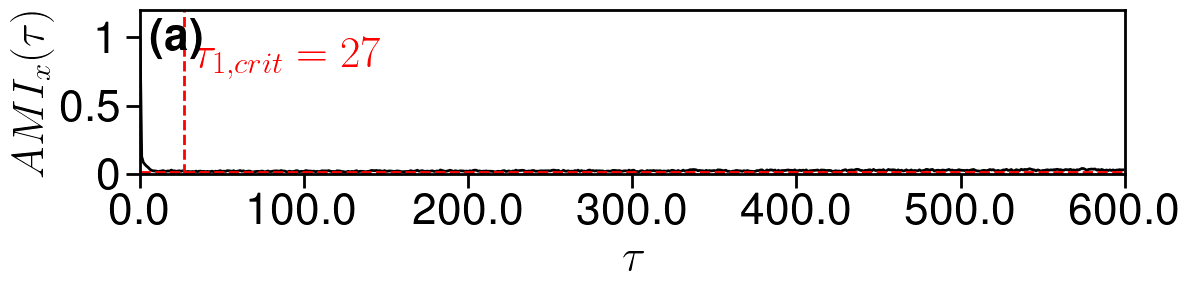

In [73]:
tau_crits = get_tau_crits(X_train, p_val=0.015, max_lag=600, make_plot=True)

In [74]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

num_runs = 20
leads = [1,3,6,12]
y_preds_TreeDOX_dict = {}
runtimes_TreeDOX_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_TreeDOX_dict[train_size] = []
    runtimes_TreeDOX_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False):
        lead = leads[i_lead]
        y_preds_TreeDOX_dict[train_size].append([None]*num_runs)
        runtimes_TreeDOX_dict[train_size].append([None]*num_runs)
        
        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=lead)
        # print(features.shape, labels.shape)

        for i_run in range(num_runs):
            start_time = time.time()
            FIs, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                                  max_depth=None, random_state=None,
                                                  n_jobs=-1, n_samples=None,
                                                  model_type='ETR')

            y_pred, model, time_elapsed = future_prediction_lead(features, labels, FIs,
                                                                 len(y_test), lead=lead,
                                                                 p=1.0, xi=xi,
                                                                 n_estimators=100,
                                                                 disp_progress=False,
                                                                 desc=str(lead),
                                                                 leave=False,
                                                                 max_depth=None,
                                                                 random_state=None,
                                                                 n_jobs=-1,
                                                                 min_samples_split=2,
                                                                 min_samples_leaf=1,
                                                                 ccp_alpha=0,
                                                                 max_features=0.5,
                                                                 n_samples=None,
                                                                 model=None,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 model_type='ETR',
                                                                 verbose=False,
                                                                 open_loop=True)
            end_time = time.time()
            y_preds_TreeDOX_dict[train_size][i_lead][i_run] = y_pred
            runtimes_TreeDOX_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 28


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [182]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_TreeDOX_dict[train_size][i_lead]))]))

177 0 0.3069677944507977
354 0 0.29986834744817714
531 0 0.29948081439565344
708 0 0.3199520477161766
885 0 0.31977676079014083
1062 0 0.3163419291810019
1239 0 0.325172719328965
1416 0 0.31548117154451194


## Plots

In [75]:
with gzip.open(data_dir + 'SOI_vary_training_results.data', 'wb') as file:
    for var in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict,
                runtimes_RNN_dict, runtimes_LSTM_dict, runtimes_RC_dict, runtimes_NGRC_dict, runtimes_TreeDOX_dict]:
        pkl.dump(var, file)

In [23]:
with gzip.open(data_dir + 'SOI_vary_training_results.data', 'rb') as file:
    for var in ['y_preds_RNN_dict', 'y_preds_LSTM_dict', 'y_preds_RC_dict', 'y_preds_NGRC_dict', 'y_preds_TreeDOX_dict',
                'runtimes_RNN_dict', 'runtimes_LSTM_dict', 'runtimes_RC_dict', 'runtimes_NGRC_dict', 'runtimes_TreeDOX_dict']:
        globals()[var] = pkl.load(file)
    
train_sizes = sorted(list(y_preds_TreeDOX_dict.keys()))

In [76]:
import pypsr as pyps

def AMI_summary(y_pred, y_test):
    return pyps.ami(y_pred, y_test)

In [77]:
soi_rmse_dict = {train_size:[[[RMSE_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_pcc_dict = {train_size:[[[PCC_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_ami_dict = {train_size:[[[AMI_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_runtimes_dict = {train_size:[[[runtimes[train_size][i_lead][i_run] for i_run in range(len(runtimes[train_size][i_lead]))] for i_lead in range(len(leads))] for runtimes in [runtimes_RNN_dict, runtimes_LSTM_dict, runtimes_RC_dict, runtimes_NGRC_dict, runtimes_TreeDOX_dict]] for train_size in train_sizes}

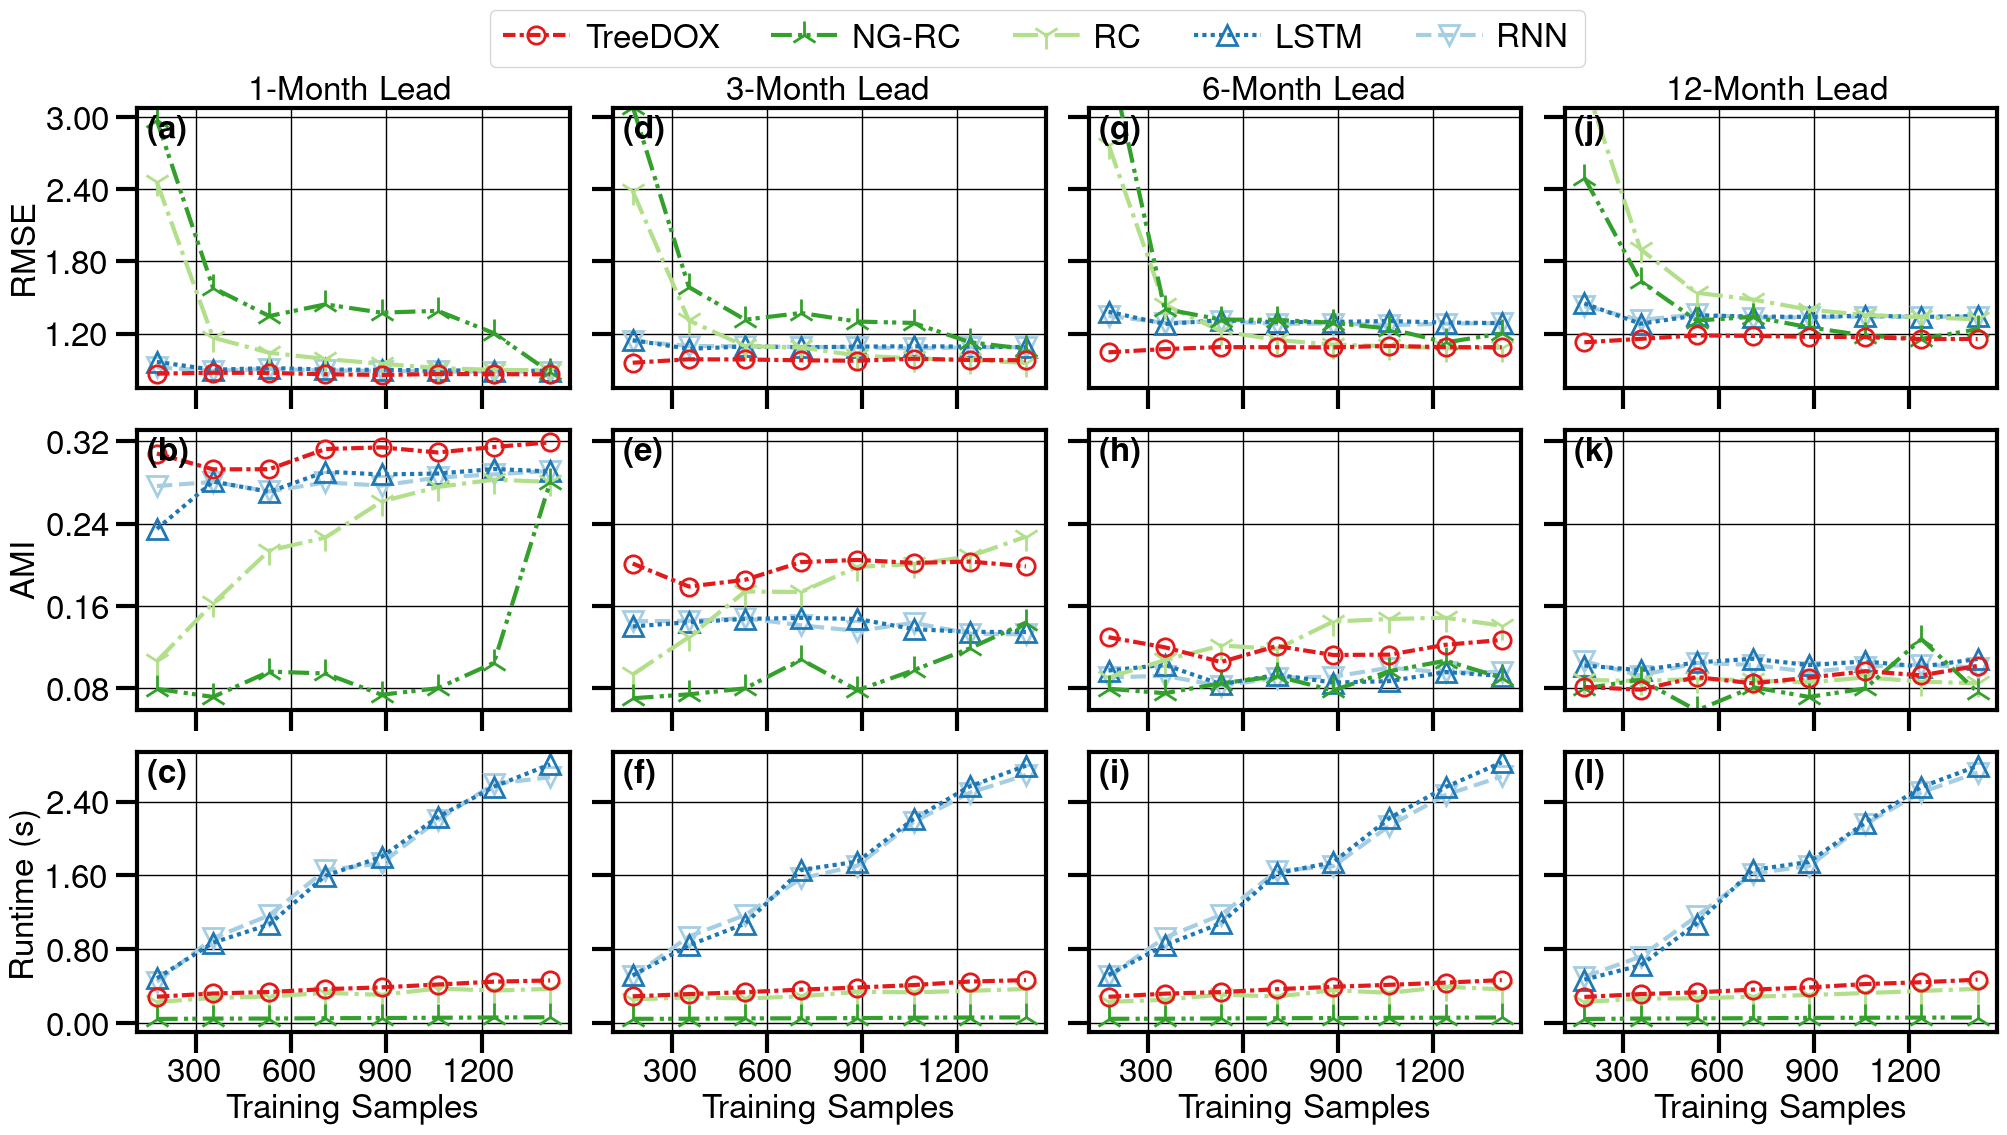

In [78]:
fname = 'SOI Vary Training Samples - TreeDOX vs RNN, LSTM, RC, NG-RC'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

vars = ['soi_rmse_dict', 'soi_ami_dict', 'soi_runtimes_dict']
var_labels = ['RMSE', 'AMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(len(vars),len(leads),figsize=(6*len(leads),4*len(vars)), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15, 15, 20, 20, 25]
marker_lst = ['v','^','1','2','.']

ylim_stretch = 0.0

for i_lead in range(len(leads)):
    for i_var in range(len(vars)):
        ax = axs[i_var,i_lead]
        
        if i_var == 0:
            ax.set_title(f'{leads[i_lead]}-Month Lead', fontsize=fontsize)

        var = globals()[vars[i_var]]

        for i_label, label in enumerate(labels):
            ax.plot(train_sizes, [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                    lw=lw_lst[i_label], ls=ls_lst[i_label], label=label, color=color_lst[i_label], zorder=10,
                    marker=marker_lst[i_label], ms=ms_lst[i_label], mew=2, mfc='none')
    #         ax.errorbar(train_sizes, [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
    #                     yerr=[np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes], fmt='none',
    #                     color=color_lst[i_label], zorder=20)

    #     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

        if i_var == len(vars)-1:
            ax.set_xlabel('Training Samples', fontsize=fontsize)
        if i_lead == 0:
            ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    #     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    #     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
    #     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


    #     if i_var == 0:
    #     ax.set_xlim(0, None)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    #     if i_var == 0:
        xticks = ax.get_xticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)

    #     if i_var == 0:
#         ax.set_ylim(0, None)
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
    #     if i_var == 0:
        yticks = ax.get_yticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

        plt.setp(ax.spines.values(), linewidth=3, zorder=100)
        ax.tick_params(length=15,width=3)

        ax.grid(True, c='k', lw=1, zorder=0)

        ax.annotate(r'\textbf{('+chr(97+i_var+len(vars)*i_lead)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

        if i_var == 0 and i_lead == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
            leg_handles, leg_labels = ax.get_legend_handles_labels()
            fig.legend(leg_handles[::-1], leg_labels[::-1], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                       columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()